# Tutorial 'unsupervised QC, and segmentatìon-free analysis of Spot-based transcriptomics data'

Author: Sebastian Tiesmeyer (sebastian.tiesmeyer@bih-charite.de)

*Affiliation: Computational Oncology group (Dr. Naveed Ishaque), Digital Health Center (Prof. Roland Eils), BIH @ Charité Hospital, Germany.*

In this part of the tutorial, we attempt data analysis without prior knowledge of cell types and their gene expression signatures. Instead, we want to find structure in the spatial set-up of the data itself.

The initial computation of a low-dimensional representation of the data takes a few minutes of time. For now, just start a session and click 'run the whole notebook' on the top to start executing. For now, you can continue in the notebook '03_1_segmentation_free_supervised' to get familiar with the general, informed exploratory workflow.

## Learning objectives:

After completing this tutorial, you will be able to:

1) Create low-dimensional representations of spatial data using plankton.py

2) Identify and remove noise

3) Explore tissue domains

4) Perform unsupervised analysis of cell types using SSAM

In [ ]:
# These seem to be necessary for linux:

%pip install ipywidgets==7.7.1 jupyterlab-widgets==1.1.1


In [ ]:

%load_ext autoreload
%autoreload 2

# widens the screen:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# imports, define a handy figure function:

import sys
import os
import plankton.plankton as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

# convenience function to create new figures:
def figure(width=8,height=8):
    plt.figure(figsize=(width,height))


In [ ]:
# root folder for the necessary data:
data_root = '../data/in_situ_sequencing'
assert os.path.exists(data_root)

# parameter definition: 
um_p_px=0.325

# load coordinates, background stain:

coordinates = pd.read_csv(os.path.join(data_root,'S2T1_pcw6.csv'))
bg = -plt.imread(os.path.join(data_root,'background.jpg')).mean(-1)
bg = (bg-bg.min())/(bg.max()-bg.min())
bg_map = pl.PixelMap(pixel_data=bg,
                     cmap='Greys',
                     px_p_um = 0.504/um_p_px)

del bg

In [ ]:
# Create sdata object:

sdata = pl.SpatialData(x_coordinates=coordinates.Global_x_pos.values*um_p_px,
                       y_coordinates=coordinates.Global_y_pos*um_p_px,
                       genes=coordinates.Gene,
                       pixel_maps={'DAPI':bg_map}
                      )

In order for the data set to compute faster, the data is supsampled using 'progressive sampling', which means that the highly occuring genes are removed with a higher probability than the lowly occurring genes. Also, the data is cropped to remove a detached structure at the top of the sample.

In [ ]:
sdata = sdata[sdata.stats.progressive_sample(1.05)] #progressive subsampling
sdata = sdata.spatial[100:2800,1000:]   #spatial cropping

## 1) Creating a low-dimensional representation to explore the data:

#### 1.0 model data as a KNN graph

In this step, the well-established UMAP algorithm is used to find a two-dimensional representation of all molecules. For each molecule, a simple model of the immediate spatial context is created. UMAP arranges the models in two-dimensional space so that molecules with similar contexts accumulate.

In [ ]:
# Parameterization for the UMAP-model:

# Parameters for the model of local molecule contexts:
knn_neighbors=100   # neighbors to use for modelling local context
bandwidth=30        # bandwidth of Gaussian kernel distance discounting
zero_weight=0.0     # Regularization term
n_ica_components=14 # Number of components for ICA initialization

# Parameters for the UMAP algorithm:
n_neighbors=55
metric='euclidean'
min_dist=0.03
random_state=3

# Determine every molecules 100 nearest neighbors:
sdata.graph.update_knn(n_neighbors=knn_neighbors)

# Run UMAP on context models:
sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight,cutoff=n_ica_components)

# save the model:
sdata.save('tutorial-umap.pl')

#### 1.1 perform UMAP embedding and visualise

We can plot the UMAP embedding and the in-situ coordinates at the same time with identical coloration:

In [ ]:
figure(20,15)

sdata.graph.map_and_umap(alpha=0.3,c=sdata.graph.umap_0)
plt.suptitle(f"nbrs:{n_neighbors}-cutoff:{n_ica_components}-bw:{bandwidth}")

In [ ]:
assert False

# stop execution for now : P

#### 1.2 Defining clusters in embedding space:

We can use an interactive javascript-based function to investigate a combined representation of the data in physical space and in local-gene-composition space.

Use the function to define: 

- A background noise signal (called bg_noise)
- Two major epithelial clusters (called epithelial_central/epithelial_distal)
- The mesothelium that encapsulates the sample (called mesothelial)
- Two clusters of mesothelium encapsulating the ducts (called mesothelial_duct_centra/mesothelial_duct_distal)
- Two clusters of the remaining tissue (called submucosa_central/submucosa_distal)

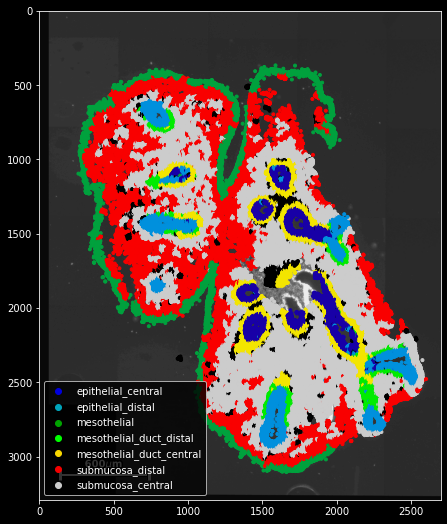

In [ ]:
# Use the javascript renderer to define tissue clusters:

# -bg_noise
# -epihtelial_central
# -epithelial_distal
# -mesothelial
# -mesotheloal_duct_central
# -mesotheloal_duct_distal
# -submucosa_central
# -submucosa_distal


sdata.graph.umap_js()

In [ ]:
sdata

In [ ]:
# sdata = pl.load('tissue_clusters.pl')
sdata.save('tissue_clusters.pl')

## 2) Identifying, investigating and removing background noise:

#### 2.1 identifying background noise:

There seems to have formed a cluster containing external noise in the data set. Environment noise can actually serve as an interesting QC indicator: In a way, it introduces a lower bound of the noise we can expect to exist within the sample.

A way to visualize the noise composition is to plot it against the observed signal:

In [ ]:
figure(12,6)

# Plot noise:
plt.subplot(121)
plt.title('noise')
sdata[sdata.bg_noise].scatter()

# Plot remaining signal:
plt.subplot(122)
plt.title('signal')
sdata[~sdata.bg_noise].scatter()


#### 2.2 comparing gene expression in background noise vs. foreground signal

The count distributions of signal and noise can be plotted against each other to identify genes that most likely to occur as noise.

This is a stacked bar plot comparing gene count compositions:

In [ ]:
from plankton.utils import hbar_compare

figure(6,10)
hbar_compare(sdata[~sdata.bg_noise].stats,sdata[sdata.bg_noise].stats,['signal','noise'])

We can see that certain genes, like COL9A1, are largely overepresented in the noise data points. We might keep these in mind and be careful whenever they re-occur in the later analysis steps.

We can also compute ratios to infer a ratio between noise and signal for each gene:

In [ ]:
count_ratios_noise = sdata[sdata.bg_noise].counts/sdata[~sdata.bg_noise].counts

figure(25,5)
count_ratios_noise.sort_values().plot.bar()
plt.title('Signal-to-count ratio:')

The next plot shows the six 'noisiest' genes plotted on top of DAPI:

In [ ]:
figure(10,10)
sdata[sdata.g.isin(count_ratios_noise.sort_values()[-6:].index)].scatter(legend=True,alpha=0.6)
plt.title('Six genes with the highest noise-to-signal-ratio:')

It appears there exist a few genes in the sample that are composed largely of noise. But already gene no. 4 on the list, LTB, shows a definite spatial pattern. Overall, this seems like a high-quality data set!

####  3.2 remove noise

As a last step, we can remove background noise by slicing it from sdata - and remove the column 'bg_noise':

In [ ]:
# slice out noise:
sdata = sdata[~sdata.bg_noise]

# drop the column 'bg_noise'
sdata = sdata.drop('bg_noise')


In [ ]:
sdata

## 3) Exploritory data analysis of tissue domains:

#### 3.1 create a new "tissue type" annotation

As a first step, we can unite the just defined individual tissue columns to one categorical column called 'tissues':

In [ ]:
figure(12,12)

tissues = sdata.columns[4:]
sdata['tissues'] = sdata.unite_columns(tissues)

sdata
# sdata[~sdata.bg_noise].scatter()

The tissue category code can now be used as a coloring argument for plotting:

In [ ]:
from matplotlib.cm import get_cmap

accent = get_cmap('nipy_spectral')

figure(9,9)
out = sdata.scatter(c=sdata.tissues.cat.codes,cmap=accent,alpha=0.1)

handlers = [plt.scatter([],[],color=accent(f)) for f in np.linspace(0.2,1,len(tissues))]

plt.legend(handlers,tissues,)


#### 3.2 identify expression patterns in tissue domains:

We can compare expression patterns and local molecule occurrence between different assigned tissue contexts:


An intuitive and simple way is to just compare the count distributions of genes within different tissues.
In order for the comparison to be meaningful, we need to make sure that the distributions are not dominated and skewed by individual outliers. Therefore, we apply a simple median-of-ratios normalization beforehand.

#### 3.2.1 gene expression patterns in the ducts

Goal of the next cells is to identify genes that are expressed in the ductal categories epithelial/mesothelial_duct:

In [ ]:
from plankton.stats import mor_normalize


# create a mask to index all 'ductal' molecules in the data set:
mask_ducts = sdata.epithelial_central|sdata.epithelial_distal|sdata.mesothelial_duct_central|sdata.mesothelial_duct_distal

# Normalize counts using the median of ratios:
normalized_counts_ducts,normalized_counts_other = mor_normalize(sdata[mask_ducts],sdata[~mask_ducts])

figure(25,5)

# Compute the log ratios, sort:
lcr_ducts = np.log2(normalized_counts_ducts/normalized_counts_other).sort_values()

# Plot the sorted ratios:
lcr_ducts.plot.bar()

plt.title('log-count-ratios for <- other vs. ductal -> genes')

This plot answers the question: *Which genes are overrepresented in the ductal regions of tissue compared to the submucosa*?

We can plot the five most significant genes:

In [ ]:
# Overoccurring in ducts:

figure(8,8)
sdata[sdata.g.isin(lcr_ducts[-5:].index)].scatter(alpha=0.5,legend=True)

plt.title('Five prominent ductal indicator genes:')

#### 3.2.2. distinguish endothelial/mesothelial cells in the ducts:

The ducts are composed out of endothelial and mesothelial cells. We can attempt to identify markers for both:

In [ ]:
# Normalize samples:
normalized_counts_epi,normalized_counts_meso = mor_normalize(sdata[sdata.epithelial_central|sdata.epithelial_distal],sdata[sdata.mesothelial_duct_central|sdata.mesothelial_duct_distal])

figure(25,5)

# Plot log-count-ratio:
lcr_epi = np.log2(normalized_counts_epi/normalized_counts_meso).sort_values()

lcr_epi.plot.bar()

plt.title('log-count-ratios  <- mesothelial vs. epithelial -> ')

In [ ]:
# Plot epithelial/mesothelial marker candidates:

epithelial_candidates = lcr_epi[-5:].index
mesothelial_candidates = lcr_epi[:5].index

figure(8,8)
sdata[sdata.g.isin(epithelial_candidates)].scatter(alpha=0.2,color='lime')
sdata[sdata.g.isin(mesothelial_candidates)].scatter(alpha=0.2,color='magenta')

# (Pssst, this is a hack to create the legend) : /
handlers = [plt.scatter([],[],color=c) for c in ['lime','magenta']]
plt.legend(handlers,['epithel','mesothel'],)

plt.title('The five most prominent indicators of epithel/mesothel:')

#### 3.2.3 distinguish mesothelial subtypes:

Mesothelial cells occur both in the walling of the developing bronchial ducts as well as in the encapsulating structure. Are there marker genes to differentiate the two?

In [ ]:
# Normalize samples:
normalized_counts_meso_duct,normalized_counts_meso = mor_normalize(sdata[sdata.mesothelial_duct_central|sdata.mesothelial_duct_distal],sdata[sdata.mesothelial])

figure(25,5)

# Plot log-count-ratio:
lcr_epi = np.log2(normalized_counts_meso_duct/normalized_counts_meso).sort_values()

lcr_epi.plot.bar()

plt.title('log-count-ratios  <- mesothelial vs. epithelial -> ')

In [ ]:
# Plot epithelial/mesothelial marker candidates:

meso_ducs_candidates = lcr_epi[-5:].index
mesothelial_candidates = lcr_epi[:4].index

figure(25,8)

plt.subplot(131)
plt.title('Ductal mesothelial')
sdata[sdata.g.isin(meso_ducs_candidates)].scatter(alpha=0.2,legend=True)

plt.subplot(132)

plt.title('General mesothelial')
sdata[sdata.g.isin(mesothelial_candidates)].scatter(alpha=0.2,legend=True)

plt.subplot(133)
sdata[sdata.g.isin(meso_ducs_candidates)].scatter(alpha=0.2,color='lime')
sdata[sdata.g.isin(mesothelial_candidates)].scatter(alpha=0.2,color='magenta')

# (Pssst, this is a hack to create the legend) : /
handlers = [plt.scatter([],[],color=c) for c in ['lime','magenta']]
plt.legend(handlers,['mesothel/duct','mesothel'],)
plt.title('The five most prominent indicators of ducal/general mesothel:')

It seems like there are genes present in the data set that have marker quality for ductal and other mesothelial cells.

#### 3.2.4 distinguishing epithelial cells:

We have discovered multiple epithelial tissue contexts. What are candidate genes that determine the individual clusters?

In [ ]:
# normalize epithelial central/distal count distributions:
norm_counts_epi_central,norm_counts_epi_distal=mor_normalize(sdata[sdata.epithelial_central].stats,sdata[sdata.epithelial_distal].stats)

figure(25,5)

lcr_epi_distal = np.log2(norm_counts_epi_central/norm_counts_epi_distal).sort_values()

lcr_epi_distal.plot.bar()
plt.title('log-count-ratios  <- epithelial_distal vs. epithelial_central -> ')

In [ ]:
# Marker candidates for epithelial central/distal:

figure(20,8)
plt.subplot(131)
plt.title('distal:')
sdata[sdata.g.isin(lcr_epi_distal[:5].index)&(sdata.epithelial_central|sdata.epithelial_distal)].scatter(alpha=0.2,legend=True)

plt.subplot(132)
plt.title('central')
sdata[sdata.g.isin(lcr_epi_distal[-5:].index)&(sdata.epithelial_central|sdata.epithelial_distal)].scatter(alpha=0.2,legend=True)

plt.subplot(133)

plt.title('Central vs. distal epithelial genes')
sdata[sdata.g.isin(lcr_epi_distal[:5].index)&(sdata.epithelial_central|sdata.epithelial_distal)].scatter(alpha=0.1,color='lime')

sdata[sdata.g.isin(lcr_epi_distal[-10:].index)&(sdata.epithelial_central|sdata.epithelial_distal)].scatter(alpha=0.1,color='magenta')


#### 3.2.5 'Central' vs. 'distal' clusters

We discovered a number of clusters that are expressed more in the center of the sample, and we can try to identify the respective genes:

In [ ]:
# Plot the clusters individually
figure(25,5)

for i,label in enumerate(['epithelial_central', 'epithelial_distal', 'mesothelial_duct_central', 'mesothelial_duct_distal', 'submucosa_central', 'submucosa_distal']):
    plt.subplot(1,7,i+1)
    
    plt.title(label)
    sdata[sdata[label]].scatter(alpha=0.3)

In [ ]:
# define central/distal tissues:
central_tissues = ['epithelial_central','mesothelial_duct_central','submucosa_central']
distal_tissues = ['epithelial_distal','mesothelial_duct_distal','submucosa_distal']

# create mask from tissues:
mask_central = sdata.tissues.isin(central_tissues)
mask_distal = sdata.tissues.isin(distal_tissues)

# plot detected central <-> distal molecules
figure()
sdata[mask_distal].scatter(color='red',alpha=0.1)
sdata[mask_central].scatter(color='yellow',alpha=0.1)
plt.title('Central vs. distal molecules:')

We can compare count ratios again to identify genes with central<->distal affinity:

In [ ]:

normalized_counts_central,normalized_counts_distal=mor_normalize(sdata[mask_central].stats,sdata[mask_distal].stats)


figure(25,5)

lcr_central = np.log2(normalized_counts_central/normalized_counts_distal).sort_values()

lcr_central.plot.bar()

plt.title('log-count-ratios  <- distal vs. central -> ')

In [ ]:
# Plot the top-12 occurring central/distal genes

figure(16,16)

plt.subplot(121)
plt.title('central genes:')
sdata[sdata.g.isin(lcr_central[-12:].index)].scatter(alpha=0.1,legend=True)


plt.subplot(122)
plt.title('distal genes:')
sdata[sdata.g.isin(lcr_central[:12].index)].scatter(alpha=0.1,legend=True)

I find it difficult to conclude whether this effect is biologial or not, and it would be interesing to find a biological explanation for this observation. It could, however, well be a technical artefact, especially given that it coincides with the expression-free 'hole' in the center of the tissue (which is probably a slicing artefact). Also, it is visible across indicator genes for different tissues at the same time. It might be due to differences in thickness of the frozen tissue sample, which resulted in different degrees of permeation by the fluids utilized in the ISS protocol. As a result, claims about the tissue compositions along the central-distal axis might need to be formulated relatively conservative.

## 4) Unsupervised approach using SSAM-denovo

Our lab has a segmentation-free, unsupervised celltype calling algorithm called SSAM  (Park, Choi, et al. 2021): https://doi.org/10.1038/s41467-021-23807-4.

It uses KDE to model an expression density of molecules in space, samples from the estimated density and creates clusters of cell types, which can then be projected onto a pixelized map of the sample:

#### 4.1 create a set of denovo cell type signatures without reference

In [ ]:
from plankton.utils import localmax_sampling,ssam

np.random.seed(0)

# create a signature matrix through local-max sampling 
signatures = pd.DataFrame(localmax_sampling(sdata,n_clusters=21,bandwidth=5),columns=sdata.genes)

# signatures are normalized along the x- and y- axes as described in the SSAM protocol:
signatures = np.array(signatures)
signatures/=signatures.sum(0)
signatures/=signatures.sum(1)[:,None]

# SSAM can be called with these signatures to perform celltype assignment:
ct_map = ssam(sdata,signatures=signatures,kernel_bandwidth=5,threshold_exp=0.1, threshold_cor=0.01)

#### 4.2 plot celltype map

In [ ]:
figure(9,9)
ct_map.imshow(cmap='nipy_spectral',interpolation='none')

#### 4.3 compare SSAM cell types to earlier identified tissue domains

We can verify the clusters by plotting them against our self-defined tissue subclasses:

In [ ]:
figure(8,75)

tissue_counts = [sdata[sdata[t]].counts for t in tissues]
# tissue_counts = pd.DataFrame(tissue_counts,index=tissues).T

for i in range(ct_map.data.max()):
    
    
    # plot tissue sections of 
    plt.subplot(ct_map.data.max(),2,i*2+2)
    
    plt.title('cluster' + str(i))
    (ct_map==i).imshow(cmap='Reds')
    
    
    plt.subplot(ct_map.data.max(),2,i*2+1)
    
    sampled = sdata[ct_map.get_value(sdata.x,sdata.y)==i]
    
    correlations = pd.Series([sampled.counts.corr(t) for t in tissue_counts],index=tissues)
    correlations.plot.barh()
#     sampled.scatter(alpha=0.5)
    
    


#### 4.4 compare SSAM unsupervised celltype map vs supervised celltype map

The fact that central/distal categories of the same tissue are often appear in the same identified cluster shows that there exists a certain amount of plausible generalization within the retrieved expression signatures.

We can also compare the identified cluster with the signatures obtained in the 'supervised' analysis. Again, interpretation is best left to a biologist:

In [ ]:
signatures = pd.read_csv('signatures.csv',index_col=0)


figure(15,175)

for i in range(ct_map.data.max()):
    
    
    # plot tissue sections of 
    plt.subplot(ct_map.data.max(),2,i*2+2)
    
    plt.title('cluster' + str(i))
    (ct_map==i).imshow(cmap='Reds')
    
    
    plt.subplot(ct_map.data.max(),2,i*2+1)
    
    sampled = sdata[ct_map.get_value(sdata.x,sdata.y)==i]
    
    correlations = pd.Series([sampled.counts.corr(t) for i,t in signatures.iterrows()],index=signatures.index)
    correlations.plot.barh()
#     sampled.scatter(alpha=0.5)
    
    


## Conclusion

...and that was it! Thanks a lot for your attention. I hope I have kindled a bit of a fire for the charms and merits of spot-based statistical analysis! 

If so, the documentation for `plankton.py` can be found at: https://plankton-py.readthedocs.io/en/latest

Also, the `squidpy` package offers a few excellent spatial statistical analysis routine implementations: https://squidpy.readthedocs.io

...and if you happen to be multilingual, the R `spatstat` package covers much of the functionality needed for any spatio-statistical analysis: http://spatstat.org/